# Plot evaluation

Makes the plots and saves them as .png and .pdf

In [1]:
#Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import Tensor
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
#Get the current working directory
basedir = os.getcwd() + '/..'

2.3.1+cu121


## Load model

In [2]:
from torch_geometric.nn import SAGEConv, to_hetero

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['source'][row], z_dict['target'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Build data

In [3]:
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData

In [4]:
def buildData(point_filepath, graph_filepath, path_save_ref):
    df=pd.read_csv(point_filepath)
    
    #Round the values of the dataset to 4 decimal places
    df = df.round(4)
    
    #Add a column to use as index from 0 to the length of the dataset
    df['n_label'] = range(0, len(df))
    
    #Empty hetero graph 
    data=HeteroData()
    
    #node names
    nodes_s=df['n_label'].values
    nodes_t=df['n_label'].values
    
    #Add nodes to the graph
    data['source'].node_id = torch.tensor(nodes_s, dtype=torch.long)
    data['target'].node_id = torch.tensor(nodes_t, dtype=torch.long)
    
    #Add node attributes, in this case the position of the points
    data['source'].x = Tensor(df[['x', 'y', 'z']].values)
    data['target'].x = Tensor(df[['x', 'y', 'z']].values)
    
    # Importing the dataset
    df_edge = pd.read_csv(graph_filepath)
    df_edge = df_edge.replace({'weight':0.5}, 0.)
    
    edge_index = torch.tensor([df_edge['Source'], df_edge['Target']], dtype=torch.long)
    data['source', 'weight', 'target'].edge_index = edge_index
    
    #edge attributes
    weight_val = torch.from_numpy(df_edge['weight'].values).to(torch.float)
    data['source', 'weight', 'target'].edge_label=weight_val
    
    data = T.ToUndirected()(data)
    
    del data['target', 'rev_weight', 'source'].edge_label
    print(data.validate(raise_on_error=True))
    
    torch.save(data, path_save_ref)
    return data

## Evaluate function

In [5]:
import torch.nn.functional as F
import math

In [6]:
def evaluate(data, path_save_pred, threshold=0.1):
    with torch.no_grad():
        data = data.to(device)
        pred = model(data.x_dict, data.edge_index_dict,
                     data['source', 'target'].edge_index)
        pred = pred.clamp(min=0, max=1)
        target = data['source', 'target'].edge_label.float()
        rmse = F.mse_loss(pred, target).sqrt()
        print(f'Test RMSE: {rmse:.4f}')
    
    sour = data['source', 'target'].edge_index[0].cpu().numpy()
    tar = data['source', 'target'].edge_index[1].cpu().numpy()
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()
    
    pred_cleaned_0 = np.zeros(pred.size)
    for id in range(sour.size):
        # First pass based on sources
        # get all possible edges with this source
        cands_sour = np.array(sour[sour==id])
        cands_pred = np.array(pred[sour==id])
        cands_ids = np.array(np.where(sour==id)[0])
        #print(cands_sour, cands_pred, cands_ids)
        max_score, max_id = -1.,-1
        # loop over cands to determine highest score
        for j in range(cands_sour.size):
            if cands_pred[j] > max(threshold,max_score):
                max_score = cands_pred[j]
                max_id = j
        # set to zero other preds
        if max_score > -1:
            for j in range(cands_sour.size):
                if j != max_id: pred_cleaned_0[cands_ids[j]] = 0.
                else: pred_cleaned_0[cands_ids[j]] = pred[cands_ids[j]]
    
    pred_cleaned = np.zeros(pred.size)
    for id in range(sour.size):
        # Second pass based on targets
        # get all possible edges with this target
        cands_t_tar = np.array(tar[tar==id])
        cands_t_pred = np.array(pred_cleaned_0[tar==id])
        cands_t_ids = np.array(np.where(tar==id)[0])
        max_score, max_id = -1.,-1
        # loop over cands to determine highest score
        for k in range(cands_t_tar.size):
            if cands_t_pred[k] > max(threshold,max_score):
                max_score = cands_t_pred[k]
                max_id = k
        # set to zero other preds
        if max_score > -1:
            for k in range(cands_t_tar.size):
                if k != max_id: pred_cleaned[cands_t_ids[k]] = 0.
                else: pred_cleaned[cands_t_ids[k]] = pred_cleaned_0[cands_t_ids[k]]
            
    
    res=pd.DataFrame({'source': sour, 'target': tar, 'pred': pred, 'pred_cleaned': pred_cleaned, 'compare': target})
    #Add a new column if pred is greater or equal than 0.5 then 1 else 0.5
    res['weight'] = np.where(res['pred_cleaned']>=threshold, 1., 0.)
    
    #compare column rating_1 with target and if they are equal add up
    cont=0
    for i in res.itertuples():
        if i.compare == i.weight:
            cont+=1
    
    #Calculate the accuracy
    accuracy = cont/len(res)
    print('Accuracy:', accuracy)
    print('Number of correct predictions:', cont)
    
    connected_accuracy = 0.
    nonconnected_accuracy = 0.
    
    n1,n2=0,0
    ncon,nncon=0,0
    for i in res.itertuples():
        if i.compare == 0.:
            if i.compare == i.weight: n1+=1
            nncon+=1
        elif i.compare == 1.0:
            if i.compare == i.weight: n2+=1
            ncon+=1
    
    connected_accuracy = n2/ncon if ncon!=0 else -1
    nonconnected_accuracy = n1/nncon if nncon!=0 else -1
    
    print(f'Accuracy in connected edges:     {n2}/{ncon} = {connected_accuracy}')
    print(f'Accuracy in non connected edges: {n1}/{nncon} = {nonconnected_accuracy}')

    acc = [accuracy, connected_accuracy, nonconnected_accuracy]
    
    pred_data = data
    pred_data['source','weight','target']['edge_label'] = torch.tensor(res['weight'], dtype=torch.long)
    torch.save(pred_data, save_pred)
    return pred_data, acc

## Plot 2D and 3D figures

In [7]:
def drawGraph(dataset, ax):

    x = dataset['source'].x
    ax.plot(x[:,0].numpy(), x[:,1].numpy(), 'g*')
    edge_index = dataset['source', 'weight', 'target'].edge_index
    edge_label = dataset['source', 'weight', 'target'].edge_label
    #edge_label_index = dataset['source', 'weight', 'target'].edge_label_index
    print(edge_index.shape)
    print(edge_label.shape)
    #print(edge_label_index.shape)

    for i, edge in enumerate(torch.t(edge_index)):
        edge1 = edge[0].numpy()
        edge2 = edge[1].numpy()
        if edge_label[i] > 0.75:
            x1, y1 = x[edge1,0], x[edge1,1]
            x2, y2 = x[edge2,0], x[edge2,1]
            xg = []
            xg.append(x1)
            xg.append(x2)
            yg = []
            yg.append(y1)
            yg.append(y2)
            ax.plot(xg, yg, 'r-')

In [8]:
def drawGraph3D(dataset, ax):
    
    x = dataset['source'].x
    #ax.plot(x[:,0].numpy(), x[:,1].numpy(), 'g*')
    ax.plot(x[:,0].numpy(), x[:,1].numpy(), x[:,2].numpy(), 'g*')

    edge_index = dataset['source', 'weight', 'target'].edge_index
    edge_label = dataset['source', 'weight', 'target'].edge_label

    for i, edge in enumerate(torch.t(edge_index)):
       
        edge1 = edge[0].numpy()
        edge2 = edge[1].numpy()
        if edge_label[i] > 0.5:
            #x1, y1 = x[edge1,0], x[edge1,1]
            #x2, y2 = x[edge2,0], x[edge2,1]
            x1, y1, z1 = x[edge1,0], x[edge1,1], x[edge1, 2]
            x2, y2, z2 = x[edge2,0], x[edge2,1], x[edge2, 2]
            xg = [] 
            xg.append(x1)
            xg.append(x2)
            yg = []
            yg.append(y1)
            yg.append(y2)
            zg = []
            zg.append(z1)
            zg.append(z2)
            #ax.plot(xg, yg, 'r-')    
            ax.plot(xg, yg, zg, 'r-')

## Track metrics

In [92]:
def giveMeNext(edge_index, edge_label, target):
    for i in range(0, len(edge_index)):
        if edge_label[i] < 0.7:
            continue
        sou = int(edge_index[i,0].numpy())
        tar = int(edge_index[i,1].numpy())
        if sou == target:
            return True, tar
    return False, -1

In [10]:
def getPartners(index, label, source):
    sourcePartner = -1
    for i, edge in enumerate(index):
        sourceP = int(edge[0].numpy())
        targetP = int(edge[1].numpy())
        if sourceP == source and label[i] > 0.5:
            sourcePartner = targetP        
    return sourcePartner

In [11]:
from tqdm import tqdm

def trackMetric(reference, prediction):
    #We identify tracks by the first node
    x = reference['source'].x
    edge_index = torch.t(reference['source', 'weight', 'target'].edge_index)
    edge_label = reference['source', 'weight', 'target'].edge_label

    lista = dict()
    #I fill the seeds for the tracks
    for i, ix in tqdm(enumerate(x)):
        r = math.sqrt(ix[0]**2 + ix[1]**2)
        if r < 11.0:
            lista[i] = []
            
    #I create the dictionary for the ground truth
    for i, edge in tqdm(enumerate(edge_index)):

        if edge_label[i] < 0.7:
            continue
        source = int(edge[0].numpy())
        target = int(edge[1].numpy())
        
        if source in lista:
            lista[source].append(source)        
            lista[source].append(target)
            continueSearching = True
            while continueSearching:
                valid, next = giveMeNext(edge_index, edge_label, target)
                if valid:
                    lista[source].append(next)
                    target = next
                else:
                    continueSearching = False
    
    #Now getting the information for the target dataset
    x_pred = prediction['source'].x
    edge_index_pred = torch.t(prediction['source', 'weight', 'target'].edge_index)
    edge_label_pred = prediction['source', 'weight', 'target'].edge_label
    
    #Creating track results
    tracks = dict()

    for source, tr in tqdm(lista.items()):
        goodLink = 0
        missingLink = 0
        fakeLink = 0
        tracks[source] = []
        for i, node in enumerate(tr):
            thesource = tr[i]
            if i < len(tr)-1:
                target = tr[i+1]
            else:
                target = -1
            sourcePartner = getPartners(edge_index_pred, edge_label_pred, thesource)
            if target == -1:
                if sourcePartner != -1:
                    fakeLink = fakeLink + 1
            else:
                if target == sourcePartner:
                    goodLink = goodLink + 1
                elif sourcePartner == -1:
                    missingLink = missingLink + 1
                else:
                    fakeLink = fakeLink + 1
        tracks[source].append(goodLink)
        tracks[source].append(fakeLink)
        tracks[source].append(missingLink)
            
    return tracks

## Main code

In [108]:
MODEL_TRACKS = '1000'
NTRACKS = [10]#[10,20,30,50,100,200,300,
WINDOW = [45]

results = dict()
for w in WINDOW:
    print(f'  - Window {w}...')
    results[str(w)] = dict()
    for n in NTRACKS:
        print(f' - {n} tracks graph...')
        results[str(w)][str(n)] = dict()
        point_path = basedir + f'/point_files/points_{n}.csv'
        graph_path = basedir + f'/graph_{w}/graph_{n}.csv'
        save_ref = f'ref_data_{n}_model{MODEL_TRACKS}_{w}.pt'
        save_pred = f'pred_data_{n}_model{MODEL_TRACKS}_{w}.pt'

        # build data
        data = buildData(point_path, graph_path, save_ref)
        # load model
        model_path = basedir + f'/final_models/model_{MODEL_TRACKS}_val100_epochs3000_{w}_all_test.pth'
        model = Model(hidden_channels=32).to(device)
        model.load_state_dict(torch.load(model_path))
        #print(model)
        # evaluate
        pred_data, acc = evaluate(data, save_pred)
        results[str(w)][str(n)]['edge_acc'] = acc

        dataset_real = torch.load(save_ref)
        dataset_pred = torch.load(save_pred)

        # track metrics
        tracks = trackMetric(dataset_real, dataset_pred)
        goodTracks = 0
        totalTracks = 0
        for s, t in tracks.items():
            #print(s, t[0], t[1], t[2])
            score = (t[0]) / (t[0] + t[1] + t[2])
            if score > 0.75: goodTracks += 1
            totalTracks += 1
        print(f'Reconstructed tracks: {goodTracks}/{totalTracks} = {goodTracks/totalTracks}')
        results[str(w)][str(n)]['track_acc'] = goodTracks/totalTracks

'''fig = plt.figure(figsize = (16, 8), layout="constrained")
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
drawGraph(data, ax1)
drawGraph(pred_data, ax2)
plt.show()'''
print(results)

  - Window 45...
 - 200 tracks graph...
True
Test RMSE: 0.3877
Accuracy: 0.8868281604844814
Number of correct predictions: 7029
Accuracy in connected edges:     1030/1800 = 0.5722222222222222
Accuracy in non connected edges: 5999/6126 = 0.9792686908259876


2000it [00:00, 119552.04it/s]
7926it [01:00, 131.24it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:19<00:00,  2.52it/s]


Reconstructed tracks: 101/200 = 0.505
 - 300 tracks graph...
True
Test RMSE: 0.3310
Accuracy: 0.9046491866958
Number of correct predictions: 14905
Accuracy in connected edges:     1358/2699 = 0.5031493145609485
Accuracy in non connected edges: 13547/13777 = 0.9833055091819699


3000it [00:00, 127294.28it/s]
16476it [02:56, 93.09it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [04:15<00:00,  1.18it/s]


Reconstructed tracks: 128/300 = 0.4266666666666667
 - 500 tracks graph...
True
Test RMSE: 0.2682
Accuracy: 0.9261709868121873
Number of correct predictions: 40733
Accuracy in connected edges:     1850/4498 = 0.411293908403735
Accuracy in non connected edges: 38883/39482 = 0.9848285294564612


5000it [00:00, 126884.80it/s]
43980it [12:12, 60.04it/s]  
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [19:17<00:00,  2.32s/it]

Reconstructed tracks: 121/500 = 0.242
{'45': {'200': {'edge_acc': [0.8868281604844814, 0.5722222222222222, 0.9792686908259876], 'track_acc': 0.505}, '300': {'edge_acc': [0.9046491866958, 0.5031493145609485, 0.9833055091819699], 'track_acc': 0.4266666666666667}, '500': {'edge_acc': [0.9261709868121873, 0.411293908403735, 0.9848285294564612], 'track_acc': 0.242}}}


In [13]:
import json
print(results)
#print(json.dumps(results, sort_keys=False, indent=2))

{'20': {'10': {'edge_acc': [0.8444444444444444, 0.8444444444444444, -1], 'track_acc': 0.9}, '20': {'edge_acc': [0.9585253456221198, 0.95, 1.0], 'track_acc': 1.0}, '30': {'edge_acc': [0.8892045454545454, 0.8814814814814815, 0.9146341463414634], 'track_acc': 0.9333333333333333}, '50': {'edge_acc': [0.8791044776119403, 0.8488888888888889, 0.9409090909090909], 'track_acc': 0.8}, '100': {'edge_acc': [0.8988326848249028, 0.8655555555555555, 0.9454828660436138], 'track_acc': 0.88}}}


In [109]:
results = dict()
results['first'] = {'20': {'10': {'edge_acc': [0.9, 0.9, 1], 'track_acc': 0.9}, 
                  '20': {'edge_acc': [0.9907834101382489, 0.9888888888888889, 1.0], 'track_acc': 1.0}, 
                  '30': {'edge_acc': [0.9090909090909091, 0.9148148148148149, 0.8902439024390244], 'track_acc': 0.9333333333333333}, 
                  '50': {'edge_acc': [0.9417910447761194, 0.9333333333333333, 0.9590909090909091], 'track_acc': 0.96}, 
                  '100': {'edge_acc': [0.930609597924773, 0.91, 0.9595015576323987], 'track_acc': 0.97}, 
                  '200': {'edge_acc': [0.9240677966101695, 0.8705555555555555, 0.9607619047619048], 'track_acc': 0.91}, 
                  '300': {'edge_acc': [0.9310064935064936, 0.8469803630974435, 0.969282700421941], 'track_acc': 0.86}, 
                  '500': {'edge_acc': [0.9330688916244928, 0.7781236104935527, 0.9730427301405219], 'track_acc': 0.766}},
           '45': {'10': {'edge_acc': [0.6344086021505376, 0.6222222222222222, 1.0], 'track_acc': 0.6}, 
                  '20': {'edge_acc': [0.7459677419354839, 0.65, 1.0], 'track_acc': 0.55}, 
                  '30': {'edge_acc': [0.7109004739336493, 0.5666666666666667, 0.9671052631578947], 'track_acc': 0.4}, 
                  '50': {'edge_acc': [0.805672268907563, 0.62, 0.9721115537848606], 'track_acc': 0.54}, 
                  '100': {'edge_acc': [0.8387228817028244, 0.6, 0.9779650032404407], 'track_acc': 0.43}, 
                  '200': {'edge_acc': [0.9096643956598537, 0.6516666666666666, 0.9854717597127], 'track_acc': 0.505}, 
                  '300': {'edge_acc': [0.9277130371449381, 0.6280103742126714, 0.9864266531175147], 'track_acc': 0.4066666666666667},
                  '500': {'edge_acc': [0.9424738517507958, 0.5409070698088039, 0.9882224811306418], 'track_acc': 0.308}}}

results['model_1000_val200_2000epochs'] = {'20': {'10': {'edge_acc': [0.8888888888888888, 0.8888888888888888, 1], 'track_acc': 0.9}, 
                                                      '20': {'edge_acc': [0.9861751152073732, 0.9833333333333333, 1.0], 'track_acc': 1.0}, 
                                                      '30': {'edge_acc': [0.8977272727272727, 0.9037037037037037, 0.8780487804878049], 'track_acc': 0.9333333333333333}, 
                                                      '50': {'edge_acc': [0.9074626865671642, 0.8888888888888888, 0.9454545454545454], 'track_acc': 0.86}, 
                                                      '100': {'edge_acc': [0.9267185473411155, 0.9077777777777778, 0.9532710280373832], 'track_acc': 0.95}, 
                                                      '200': {'edge_acc': [0.9161581920903955, 0.8583333333333333, 0.9558095238095238], 'track_acc': 0.855}},
                                               '45': {'10': {'edge_acc': [0.6021505376344086, 0.5888888888888889, 1.0], 'track_acc': 0.5}, 
                                                      '20': {'edge_acc': [0.7419354838709677, 0.6444444444444445, 1.0], 'track_acc': 0.6}, 
                                                      '30': {'edge_acc': [0.6706161137440758, 0.5037037037037037, 0.9671052631578947], 'track_acc': 0.4}, 
                                                      '50': {'edge_acc': [0.773109243697479, 0.5733333333333334, 0.952191235059761], 'track_acc': 0.5}, 
                                                      '100': {'edge_acc': [0.820712239050348, 0.5466666666666666, 0.9805573558003888], 'track_acc': 0.45}, 
                                                      '200': {'edge_acc': [0.8800151400454201, 0.5544444444444444, 0.975677440417891], 'track_acc': 0.4}}}

results['model_1000_val300_3000epochs'] = {'20': {'10': {'edge_acc': [0.8444444444444444, 0.8444444444444444, 1], 'track_acc': 0.9}, 
                                                      '20': {'edge_acc': [0.9585253456221198, 0.95, 1.0], 'track_acc': 1.0}, 
                                                      '30': {'edge_acc': [0.8892045454545454, 0.8814814814814815, 0.9146341463414634], 'track_acc': 0.9333333333333333}, 
                                                      '50': {'edge_acc': [0.8791044776119403, 0.8488888888888889, 0.9409090909090909], 'track_acc': 0.8}, 
                                                      '100': {'edge_acc': [0.8988326848249028, 0.8655555555555555, 0.9454828660436138], 'track_acc': 0.88},
                                                      '200': {'edge_acc': [0.8888135593220339, 0.7766666666666666, 0.9657142857142857], 'track_acc': 0.815}, 
                                                      '300': {'edge_acc': [0.9010899814471243, 0.7532419414598, 0.9684388185654008], 'track_acc': 0.7266666666666667}, 
                                                      '500': {'edge_acc': [0.9066703141385127, 0.6431747443308137, 0.974648695153427], 'track_acc': 0.566}},
                                               '45': {'10': {'edge_acc': [0.6666666666666666, 0.6555555555555556, 1.0], 'track_acc': 0.4}, 
                                                      '20': {'edge_acc': [0.75, 0.6555555555555556, 1.0], 'track_acc': 0.4}, 
                                                      '30': {'edge_acc': [0.7345971563981043, 0.6148148148148148, 0.9473684210526315], 'track_acc': 0.43333333333333335}, 
                                                      '50': {'edge_acc': [0.7951680672268907, 0.5977777777777777, 0.9721115537848606], 'track_acc': 0.42}, 
                                                      '100': {'edge_acc': [0.8440442079410561, 0.6077777777777778, 0.981853532080363], 'track_acc': 0.45}}}

results['model_1000_val100_3000epochs'] = {'20': {'10': {'edge_acc': [0.9, 0.9, 1], 'track_acc': 0.9}, 
                                                  '20': {'edge_acc': [0.9815668202764977, 0.9777777777777777, 1.0], 'track_acc': 1.0}, 
                                                  '30': {'edge_acc': [0.9176136363636364, 0.9185185185185185, 0.9146341463414634], 'track_acc': 0.9333333333333333}, 
                                                  '50': {'edge_acc': [0.9432835820895522, 0.9355555555555556, 0.9590909090909091], 'track_acc': 0.96}, 
                                                  '100': {'edge_acc': [0.9345006485084306, 0.9077777777777778, 0.9719626168224299], 'track_acc': 0.96}, 
                                                  '200': {'edge_acc': [0.9446327683615819, 0.895, 0.9786666666666667], 'track_acc': 0.965}, 
                                                  '300': {'edge_acc': [0.9373840445269017, 0.8543905150055576, 0.9751898734177216], 'track_acc': 0.8633333333333333}, 
                                                  '500': {'edge_acc': [0.9466101308530525, 0.8128056914184082, 0.9811299110983653], 'track_acc': 0.796}},
                                           '45': {'10': {'edge_acc': [0.4946236559139785, 0.4777777777777778, 1.0], 'track_acc': 0.5}, 
                                                  '20': {'edge_acc': [0.6774193548387096, 0.5555555555555556, 1.0], 'track_acc': 0.6}, 
                                                  '30': {'edge_acc': [0.7464454976303317, 0.6074074074074074, 0.993421052631579], 'track_acc': 0.6333333333333333}, 
                                                  '50': {'edge_acc': [0.7720588235294118, 0.5533333333333333, 0.9681274900398407], 'track_acc': 0.58}, 
                                                  '100': {'edge_acc': [0.803520261972984, 0.5011111111111111, 0.9799092676604018], 'track_acc': 0.48}, 
                                                  '200': {'edge_acc': [0.8868281604844814, 0.5722222222222222, 0.9792686908259876], 'track_acc': 0.505}, 
                                                  '300': {'edge_acc': [0.9046491866958, 0.5031493145609485, 0.9833055091819699], 'track_acc': 0.4266666666666667}, 
                                                  '500': {'edge_acc': [0.9261709868121873, 0.411293908403735, 0.9848285294564612], 'track_acc': 0.242}}}

## Efficiency plots

In [104]:
plt.rcParams['axes.linewidth'] = 1.2

def plotAcc(results, window):
    ntracks = []
    total_acc = []
    connected_acc = []
    nonconnected_acc = []
    for key in results[window]:
        ntracks.append(int(key))
        total_acc.append(results[window][key]['edge_acc'][0])
        connected_acc.append(results[window][key]['edge_acc'][1])
        nonconnected_acc.append(results[window][key]['edge_acc'][2])
    
    # Create the figure and subplot
    fig, ax = plt.subplots(figsize=(5, 5))
    
    ax.tick_params(axis='both', which='major', direction='in', color='k', length=5, top=True, right=True)
    ax.tick_params(axis='both', which='minor', direction='in', color='k', length=2, top=True, right=True)
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.02))
    
    # Set the aspect ratio to be square
    #ax.set_aspect('equal')
    
    # Create the plot with different colors
    ax.plot(ntracks, total_acc, marker='.', color='k', label='Total')  # Blue line
    ax.plot(ntracks, connected_acc, marker='.', color='g', label='Connected edges')  # Red line
    ax.plot(ntracks, nonconnected_acc, marker='.', color='r', label='Disconnected edges')  # Green line
    
    # Add grid lines
    ax.grid(True)
    
    # Add a title and labels
    ax.set_title('')
    ax.set_xlabel('Number of tracks', labelpad=10, loc='right')
    ax.set_ylabel('Accuracy', labelpad=10, loc='top')
    
    ax.set_xscale('log')
    ax.set_xlim(10, 1000)
    ax.set_ylim(0,1.2)
    
    # Add a legend
    plt.legend(bbox_to_anchor=(0.9,0.1), loc="lower right", title=f'Window {window}º')
    
    plt.tight_layout()
    plt.grid(visible=True, which='major', axis='both', linestyle='--', color='silver')
    plt.grid(visible=True, which='minor', axis='both', linestyle='--', color='whitesmoke')
    
    # Show the plot
    plt.show()
    return fig

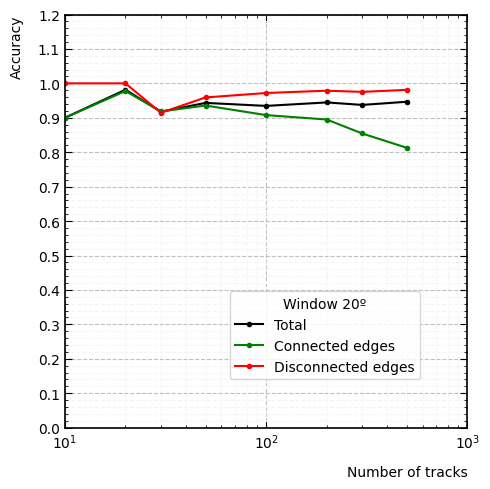

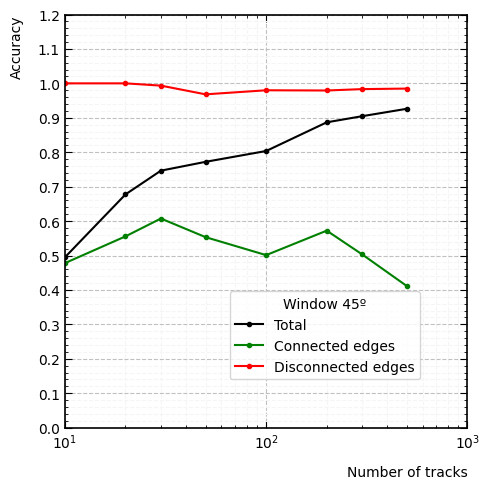

In [110]:
modelname = 'model_1000_val100_3000epochs'
fig_acc_20 = plotAcc(results[modelname], '20')
fig_acc_45 = plotAcc(results[modelname], '45')
fig_acc_20.savefig(f'figures/fig_{modelname}_20_accuracies.png', transparent=True, format='png')
fig_acc_20.savefig(f'figures/fig_{modelname}_20_accuracies.pdf', transparent=True, format='pdf')
fig_acc_45.savefig(f'figures/fig_{modelname}_45_accuracies.png', transparent=True, format='png')
fig_acc_45.savefig(f'figures/fig_{modelname}_45_accuracies.pdf', transparent=True, format='pdf')

In [113]:
plt.rcParams['axes.linewidth'] = 1.2

def plotTrackReco(results):
    ntracks = dict()
    track_acc = dict()
    for window in ['20','45']:
        ntracks[window] = []
        track_acc[window] = []
        for key in results[window]:
            ntracks[window].append(int(key))
            track_acc[window].append(results[window][key]['track_acc'])

    # Create the figure and subplot
    fig, ax = plt.subplots(figsize=(5, 5))
    
    ax.tick_params(axis='both', which='major', direction='in', color='k', length=5, top=True, right=True)
    ax.tick_params(axis='both', which='minor', direction='in', color='k', length=2, top=True, right=True)
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.02))
    ax.xaxis.set_major_locator(plt.LogLocator(base=10, subs=(0.1,)))
    #ax.xaxis.set_minor_locator(plt.LogLocator(base=10))
    
    # Set the aspect ratio to be square
    #ax.set_aspect('equal')
    
    # Create the plot with different colors
    ax.plot(ntracks['20'], track_acc['20'], marker='.', color='orange', label='20º')
    ax.plot(ntracks['45'], track_acc['45'], marker='.', color='b', label='45º')
    
    # Add grid lines
    ax.grid(True)
    
    # Add a title and labels
    ax.set_title('Track reconstruction efficiency')
    ax.set_xlabel('Number of tracks', labelpad=10, loc='right')
    ax.set_ylabel('Efficiency', labelpad=10, loc='top')
    
    ax.set_xscale('log')
    ax.set_xlim(10, 1000)
    ax.set_ylim(0,1.2)
    
    # Add a legend
    plt.legend(bbox_to_anchor=(0.6,0.1), loc="lower right")
    
    plt.tight_layout()
    plt.grid(visible=True, which='major', axis='both', linestyle='--', color='silver')
    plt.grid(visible=True, which='minor', axis='both', linestyle='--', color='whitesmoke')
    
    # Show the plot
    plt.show()
    return fig

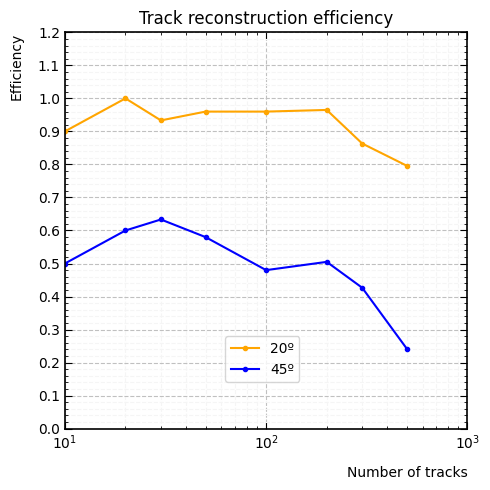

In [114]:
fig_trackeff = plotTrackReco(results[modelname])
fig_trackeff.savefig(f'figures/fig_{modelname}_recoeff.png', transparent=True, format='png')
fig_trackeff.savefig(f'figures/fig_{modelname}_recoeff.pdf', transparent=True, format='pdf')

## Loss plot

In [115]:
lossdf = pd.read_csv('loss_values_1000_val100_epochs3000_20_all_test.txt', header=None, names=['Epoch','Loss','Train','Val'])
lossdf

,Epoch,Loss,Train,Val
0,1,82.4976,0.7329,0.6820
1,2,45.5109,0.6180,0.6703
2,3,21.4571,0.4756,0.6516
3,4,3.5249,0.4744,0.6845
4,5,5.1918,0.5275,0.6808
...,...,...,...,...
2995,2996,0.0421,0.2029,0.3750
2996,2997,0.0417,0.2032,0.3730
2997,2998,0.0418,0.2027,0.3796
2998,2999,0.0421,0.2034,0.3725


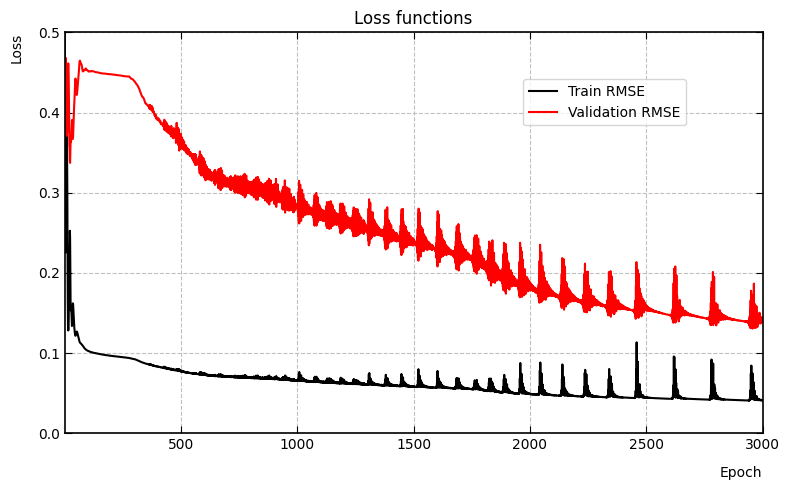

In [116]:
epochs = lossdf['Epoch'].to_numpy()
loss = lossdf['Loss'].to_numpy()
train = lossdf['Train'].to_numpy()
val = lossdf['Val'].to_numpy()

# Create the figure and subplot
fig, ax = plt.subplots(figsize=(8, 5))

ax.tick_params(axis='both', which='major', direction='in', color='k', length=5, top=True, right=True)
ax.tick_params(axis='both', which='minor', direction='in', color='k', length=2, top=True, right=True)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.02))
ax.xaxis.set_major_locator(plt.LogLocator(base=10, subs=(0.1,)))

#  Create the plot with different colors
#ax.plot(epochs, loss, marker='', color='b', label='Loss')  # Blue line
ax.plot(epochs, train*train, marker='', color='k', label='Train RMSE')  # Red line
ax.plot(epochs, val*val, marker='', color='r', label='Validation RMSE')  # Green line

# Add a title and labels
ax.set_title('Loss functions')
ax.set_xlabel('Epoch', labelpad=10, loc='right')
ax.set_ylabel('Loss', labelpad=10, loc='top')

ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlim(1, 3000)
ax.set_ylim(0., 0.5)

# Add grid lines
ax.grid(True)

# Add a legend
plt.legend(bbox_to_anchor=(0.9,0.9), loc="upper right")

plt.tight_layout()
plt.grid(visible=True, which='major', axis='both', linestyle='--', color='silver')
plt.grid(visible=True, which='minor', axis='both', linestyle='--', color='whitesmoke')

# Show the plot
plt.show()

fig.savefig(f'figures/fig_{modelname}_20_loss.png', transparent=True, format='png')
fig.savefig(f'figures/fig_{modelname}_20_loss.pdf', transparent=True, format='pdf')

In [117]:
lossdf = pd.read_csv('loss_values_1000_val100_epochs3000_45_all_test.txt', header=None, names=['Epoch','Loss','Train','Val'])
lossdf

,Epoch,Loss,Train,Val
0,1,22.8230,0.7339,0.7892
1,2,125.7657,0.7357,0.7511
2,3,14.8815,0.6584,0.6021
3,4,17.2849,0.5958,0.5773
4,5,29.2295,0.5098,0.5767
...,...,...,...,...
2995,2996,0.0410,0.2020,0.5138
2996,2997,0.0410,0.2020,0.5138
2997,2998,0.0410,0.2020,0.5138
2998,2999,0.0410,0.2020,0.5137


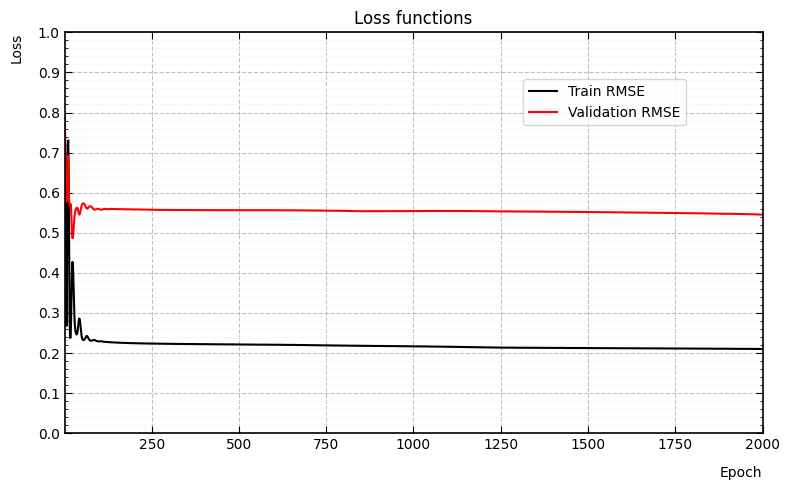

In [118]:
epochs = lossdf['Epoch'].to_numpy()
loss = lossdf['Loss'].to_numpy()
train = lossdf['Train'].to_numpy()
val = lossdf['Val'].to_numpy()

# Create the figure and subplot
fig, ax = plt.subplots(figsize=(8, 5))

ax.tick_params(axis='both', which='major', direction='in', color='k', length=5, top=True, right=True)
ax.tick_params(axis='both', which='minor', direction='in', color='k', length=2, top=True, right=True)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.02))
ax.xaxis.set_major_locator(plt.LogLocator(base=10, subs=(0.1,)))

#  Create the plot with different colors
#ax.plot(epochs, loss, marker='', color='b', label='Loss')  # Blue line
ax.plot(epochs, train, marker='', color='k', label='Train RMSE')  # Red line
ax.plot(epochs, val, marker='', color='r', label='Validation RMSE')  # Green line

# Add a title and labels
ax.set_title('Loss functions')
ax.set_xlabel('Epoch', labelpad=10, loc='right')
ax.set_ylabel('Loss', labelpad=10, loc='top')

ax.set_xscale('linear')
ax.set_xlim(1, 2000)
ax.set_ylim(0., 1.)

# Add grid lines
ax.grid(True)

# Add a legend
plt.legend(bbox_to_anchor=(0.9,0.9), loc="upper right")

plt.tight_layout()
plt.grid(visible=True, which='major', axis='both', linestyle='--', color='silver')
plt.grid(visible=True, which='minor', axis='both', linestyle='--', color='whitesmoke')

# Show the plot
plt.show()

fig.savefig(f'figures/fig_{modelname}_45_loss.png', transparent=True, format='png')
fig.savefig(f'figures/fig_{modelname}_45_loss.pdf', transparent=True, format='pdf')